In [1]:
!pwd
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu113\\python.exe'

# 犬猫の画像で多クラス分類モデル試す
## <font color="Red">クラスごとに画像ディレクトリ別れてる場合で分類モデル作成<font>

#### 自宅PC:tfgpu_py36_v2環境
- C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\experiment 

#### 犬猫画像は以下のサイトから取得できた
- https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765


## モジュールimport

In [1]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, grad_cam, ensemble_predict, base_predict
from tuning import optuna_train_base, optuna_train_Tox21, optuna_util

import pathlib
#current_dir = pathlib.Path("__file__").resolve().parent
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\Git\keras-squeeze-excite-network')
import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

import glob, time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pathlib

%matplotlib inline
%reload_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))# 75%

C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


optuna_train_base.py: loaded as module file
optuna_train.py: loaded as module file
optuna_util.py: loaded as module file


## 画像をtrain/validation/test set に分ける
- train_count=500*2
- valid_count=200*2
- test_count=100*2

import os, shutil, glob
from tqdm import tqdm

def split_class_train_valid_test_set(class_name_list, source_dir, img_dir
                                     , train_count=500, valid_count=200, test_count=100):
    """
    クラスディレクトリごとに別れた指定ディレクトリの画像を tarin/val set に分けてコピーする
    クラスごとの画像枚数の指定（train_count, valid_count, test_count）がなければ train:0.7, valid:0.2, test:0.1 の割合でコピー
    """

    print('source_dir :', source_dir)
    print('img_dir :', img_dir)
    print('---------------------------------------------------------------')
    for class_name in class_name_list:
        print('class_name :', class_name)
        # クラスごとの画像総数
        class_source_dir = os.path.join(source_dir, class_name)
        # ファイル名一応ソートしておく
        id_imgs = sorted(glob.glob(os.path.join(class_source_dir, '*jpg')))
        print('imgs:', len(id_imgs))

        # 画像ディレクトリ作成
        train_dir = os.path.join(img_dir, 'train', class_name)
        valid_dir = os.path.join(img_dir, 'validation', class_name)
        test_dir = os.path.join(img_dir, 'test', class_name)
        os.makedirs(train_dir, exist_ok=True)
        os.makedirs(valid_dir, exist_ok=True)
        os.makedirs(test_dir, exist_ok=True)

        # train/validation/test set に分ける画像枚数していなければ 7:2:1 で分ける
        if train_count is None:
            test_count =  int(len(id_imgs)*0.1)
            valid_count = int(len(id_imgs)*0.2)
            train_count = len(id_imgs) - valid_count - test_count

        # test img copy
        for img in tqdm(id_imgs[0: test_count]):
            shutil.copyfile(img, os.path.join(test_dir, os.path.basename(img)))
        # validation img copy
        for img in tqdm(id_imgs[test_count: valid_count+test_count]):
            shutil.copyfile(img, os.path.join(valid_dir, os.path.basename(img)))
        # train img copy
        for img in tqdm(id_imgs[valid_count+test_count: train_count+valid_count+test_count]):
            shutil.copyfile(img, os.path.join(train_dir, os.path.basename(img)))


# クラス名のリスト
class_name = ['Cat', 'Dog']

# cat, dog 全画像格納しているディレクトリ
source_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\kagglecatsanddogs_3367a\PetImages'

# train/validation/test set に分ける画像ディレクトリ
img_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set'

train_1class_count = 500 # train 1クラスの画像枚数
valid_1class_count = 200 # validaiton 1クラスの画像枚数
test_1class_count = 100  # test 1クラスの画像枚数

# クラスディレクトリごとに別れた指定ディレクトリの画像を tarin/val set に分けてコピーする
split_class_train_valid_test_set(class_name, source_dir, img_dir
                                 , train_count=train_1class_count
                                 , valid_count=valid_1class_count
                                 , test_count=test_1class_count
                                )

## パラメータ設定

In [3]:
import keras
import os, sys, glob, time

# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py'
os.makedirs(output_dir, exist_ok=True)

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = util.file_count(train_data_dir, r'.jpg')

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = util.file_count(validation_data_dir, r'.jpg')

# テスト画像ディレクトリ
test_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test'

# 入力層のサイズ
#img_rows, img_cols, channels=331, 331, 3
img_rows, img_cols, channels=100, 100, 3

# 分類クラス
class_name = ['Cat', 'Dog']
classes = class_name#['0', '1']
nb_classes = len(classes)
activation='softmax'

# GradCamで切り出す層名
layer_name = 'multiply_1'

# ハイパーパラメータ
num_epoch=5#10
batch_size=10
val_batch_size=10
test_batch_size=10

# optimizer のパラメータ
choice_optim='sgd'
lr=0.1 * batch_size / 128
#decay=1e-3
momentum=0.9

# fine-tuningモデル
choice_model='InceptionResNetV2'
trainable=761

# 全結合層
FCnum=1

# 学習打ち切りオプション
early_stopping=10

plateau_pati=5
plateau_factor=0.5 # コールバックが起動したら学習率0.9倍
plateau_monitor='val_loss'

# https://qiita.com/ak11/items/67118e11b756b0ee83a5
base_lr = lr #0.1 * batch_size / 128  # adamとかなら1e-3くらい。SGDなら例えば 0.1 * batch_size / 128 とかくらい。nadamなら0.002*10 ?
lr_decay_rate = 1/2#1 / 3
lr_steps = 2#4

### 訓練画像水増しオプション
# ImageDataGenerator
rescale=1.0/255.0
vertical_flip=True
zoom_range=0.2
rotation_range=20
channel_shift_range=5.
brightness_range=[0.3, 1.0]
# custom param
mix_up_alpha=0.2# mixup alpha
#random_crop=[224,224]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255
ricap_beta=0.3 # RICAP beta
ricap_use_same_random_value_on_batch=True # Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」
is_base_aug=True # 下山さんが使っていたAutoAugmentのデフォルト？変換入れるか

# MyImageDataGenerator のオプションを辞書型で詰める
my_IDG_options={'rescale': rescale
             , 'vertical_flip': vertical_flip
             , 'zoom_range': zoom_range
             , 'rotation_range': rotation_range 
             , 'channel_shift_range': channel_shift_range
             , 'brightness_range': brightness_range
             , 'mix_up_alpha': mix_up_alpha
             , 'random_erasing_prob': random_erasing_prob
             , 'random_erasing_maxpixel': random_erasing_maxpixel
             , 'ricap_beta': ricap_beta
             , 'ricap_use_same_random_value_on_batch': ricap_use_same_random_value_on_batch
             #, 'is_base_aug': is_base_aug
            }

## data generator定義
- データ管理クラス：d_cls

In [4]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=val_batch_size
                                            , test_batch_size=test_batch_size)

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , classes
                                              , valid_data_dir=validation_data_dir
                                              , test_data_dir=test_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options
                                              , is_valid_grayscale=False # validation generatorをグレースケール化するか
                                             )

my_IDG_options: {'rescale': 0.00392156862745098, 'vertical_flip': True, 'zoom_range': 0.2, 'rotation_range': 20, 'channel_shift_range': 5.0, 'brightness_range': [0.3, 1.0], 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


(<generator object MyImageDataGenerator.flow_from_directory at 0x000001EBED137258>,
 <keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x1ebdbf520f0>)

In [5]:
dir(d_cls.train_gen)

['__class__',
 '__del__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__name__',
 '__ne__',
 '__new__',
 '__next__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'close',
 'gi_code',
 'gi_frame',
 'gi_running',
 'gi_yieldfrom',
 'send',
 'throw']

In [6]:
dir(d_cls.valid_gen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'labels',
 'lock',
 'n',
 'next',
 'num_classes',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'samples',
 'save_format',
 'save_prefix',
 'save_to_dir',
 'seed',
 'set_processing_attrs',
 'shuffle',
 'sp

Found 1000 images belonging to 2 classes.
(10, 100, 100, 3)
[[[0.59205665 0.58890925 0.5543893 ]
  [0.56669267 0.58002262 0.53818128]
  [0.54917182 0.57165773 0.52693832]
  ...
  [0.56862747 0.55686277 0.50980394]
  [0.57647061 0.56078433 0.51764708]
  [0.56862747 0.5529412  0.50980394]]

 [[0.53845061 0.55989303 0.50157434]
  [0.52720765 0.55780603 0.50157434]
  [0.53845061 0.55780603 0.51569537]
  ...
  [0.52549022 0.50980395 0.46666669]
  [0.57254904 0.55686277 0.50980394]
  [0.56078434 0.54509806 0.49803923]]

 [[0.45528969 0.47516686 0.42521305]
  [0.45998542 0.48614049 0.43330861]
  [0.62578552 0.63441974 0.60198678]
  ...
  [0.54901963 0.53333336 0.48627453]
  [0.57647061 0.56078434 0.51764708]
  [0.53333336 0.51764708 0.47450983]]

 ...

 [[0.27673909 0.2999783  0.37291785]
  [0.16743148 0.21907088 0.32115367]
  [0.17824698 0.2351287  0.33403301]
  ...
  [0.64879318 0.61085651 0.61216933]
  [0.66998323 0.62812494 0.63048126]
  [0.65534041 0.60903884 0.61035167]]

 [[0.48767663 

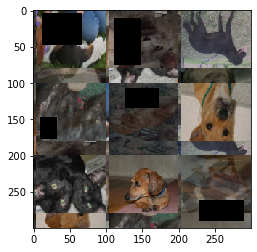

In [7]:
def print_gen(gen, i=0):
    x,y = next(gen)
    print(x.shape)
    print(x[i])
    print(np.max(x))
    print(y.shape)
    print(y[i])
    util.show_tile_img(x)
    #for ii in range(len(y)):
    #    plt.imshow(x[ii])
    #    plt.show()

print_gen(d_cls.train_gen, i=5)

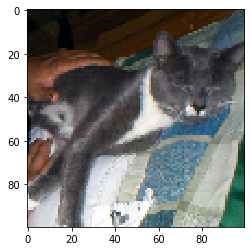

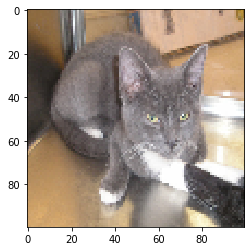

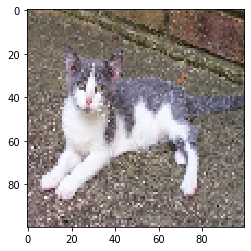

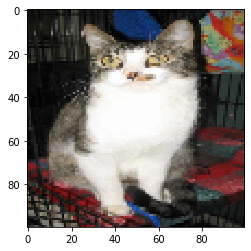

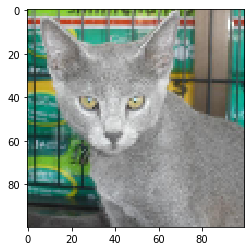

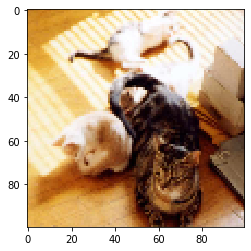

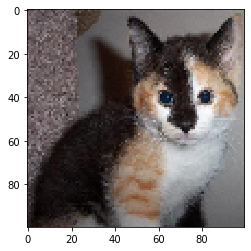

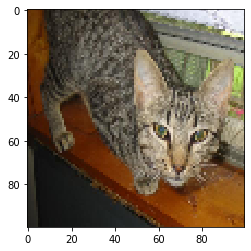

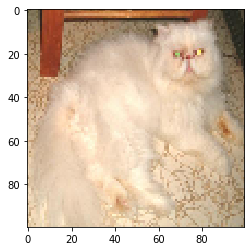

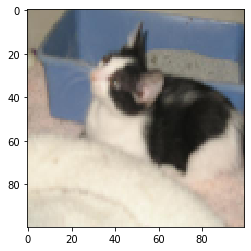

In [8]:
def print_gen(gen, i=0):
    x,y = next(gen)
    for ii in range(len(y)):
        plt.imshow(x[ii])
        plt.show()

print_gen(d_cls.valid_gen, i=10)

### グレースケール化確認

In [9]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=val_batch_size
                                            , test_batch_size=test_batch_size)

d_cls.create_my_generator_flow_from_directory(train_data_dir
                                              , classes
                                              , valid_data_dir=validation_data_dir
                                              , test_data_dir=test_dir
                                              , color_mode='rgb'
                                              , class_mode='categorical'
                                              , my_IDG_options=my_IDG_options
                                              , is_valid_grayscale=True # validation generatorをグレースケール化するか
                                             )

my_IDG_options: {'rescale': 0.00392156862745098, 'vertical_flip': True, 'zoom_range': 0.2, 'rotation_range': 20, 'channel_shift_range': 5.0, 'brightness_range': [0.3, 1.0], 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True}
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


(<generator object MyImageDataGenerator.flow_from_directory at 0x000001EBEE936678>,
 <keras_preprocessing.image.directory_iterator.DirectoryIterator at 0x1ebee9c1668>)

In [10]:
dir(d_cls.valid_gen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_set_index_array',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'labels',
 'lock',
 'n',
 'next',
 'num_classes',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'samples',
 'save_format',
 'save_prefix',
 'save_to_dir',
 'seed',
 'set_processing_attrs',
 'shuffle',
 'sp

(10, 100, 100, 3)
[[[0.43529415 0.43529415 0.43529415]
  [0.41960788 0.41960788 0.41960788]
  [0.43529415 0.43529415 0.43529415]
  ...
  [0.48235297 0.48235297 0.48235297]
  [0.57254905 0.57254905 0.57254905]
  [0.43921572 0.43921572 0.43921572]]

 [[0.42352945 0.42352945 0.42352945]
  [0.42352945 0.42352945 0.42352945]
  [0.4431373  0.4431373  0.4431373 ]
  ...
  [0.5568628  0.5568628  0.5568628 ]
  [0.58431375 0.58431375 0.58431375]
  [0.44705886 0.44705886 0.44705886]]

 [[0.427451   0.427451   0.427451  ]
  [0.43137258 0.43137258 0.43137258]
  [0.43529415 0.43529415 0.43529415]
  ...
  [0.5764706  0.5764706  0.5764706 ]
  [0.56078434 0.56078434 0.56078434]
  [0.47450984 0.47450984 0.47450984]]

 ...

 [[0.6745098  0.6745098  0.6745098 ]
  [0.6862745  0.6862745  0.6862745 ]
  [0.67058825 0.67058825 0.67058825]
  ...
  [0.10588236 0.10588236 0.10588236]
  [0.12156864 0.12156864 0.12156864]
  [0.20000002 0.20000002 0.20000002]]

 [[0.67058825 0.67058825 0.67058825]
  [0.6784314  0.678

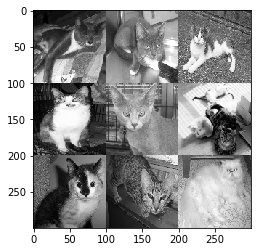

In [11]:
def print_gen(gen, i=0):
    x,y = next(gen)
    print(x.shape)
    print(x[i])
    print(np.max(x))
    print(y.shape)
    print(y[i])
    util.show_tile_img(x)
    #for ii in range(len(y)):
    #    plt.imshow(x[ii])
    #    plt.show()

print_gen(d_cls.valid_gen, i=1)

## ニューラルネットワーク定義

- InceptionResNetV2+attension
- 761層以前をfreeze(ただし、Batch Normalizationはfreeze解除)

In [13]:
# モデル定義
model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels, nb_classes
                                                       , choice_model, trainable
                                                       , fcpool='attention'
                                                       , activation=activation
                                                      )
# compile the model
optim = define_model.get_optimizers(choice_optim=choice_optim, lr=lr, momentum=momentum, nesterov=True)#, decay=decay)
#lr_metric = my_metric.get_lr_metric(optim)
model.compile(loss='categorical_crossentropy'
              , optimizer=optim
              , metrics=['accuracy'])
              #, metrics=['accuracy', lr_metric])

# finetunning用にレイヤーの数と名前を表示
count= 0
for layer in model.layers:
    print(count, layer.name)
    count+=1
keras.utils.plot_model(model, to_file=os.path.join(output_dir, 'InceptionResNetV2_attention.svg'), show_shapes=True)

model.summary()

----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = InceptionResNetV2 761
fcs = []
fcpool = attention
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
inception_resnet_v2 (Model)     (None, 1, 1, 1536)   54336736    input_2[0][0]                    
__________

In [14]:
define_model.print_model_summary(model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
inception_resnet_v2 (Model)     (None, 1, 1, 1536)   54336736    input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 1, 1, 1536)   6144        inception_resnet_v2[1][0]        
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 1, 1536)   0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_204

## callback

In [15]:
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(epochs=num_epoch))

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping, verbose=1))
    
    return cb

## 学習実行

In [16]:
%%time
start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen,
    steps_per_epoch = train_samples//batch_size,# 1エポックあたりの学習(step)回数
    epochs = num_epoch,# エポック数
    validation_data = d_cls.valid_gen,# 検証ファイル生成
    validation_steps = val_samples//val_batch_size,# 検証するファイル数
    verbose = 2,# 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    callbacks = get_cb(output_dir, cosine_annealing_num_epoch=None)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
Found 1000 images belonging to 2 classes.
 - 31s - loss: 1.1207 - acc: 0.4890 - val_loss: 1.6264 - val_acc: 0.4850

Epoch 00001: val_loss improved from inf to 1.62641, saving model to D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py\finetuning.h5
Epoch 2/5
 - 12s - loss: 1.0931 - acc: 0.4950 - val_loss: 1.5945 - val_acc: 0.4925

Epoch 00002: val_loss improved from 1.62641 to 1.59454, saving model to D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py\finetuning.h5
Epoch 3/5
 - 12s - loss: 1.0200 - acc: 0.5160 - val_loss: 1.5832 - val_acc: 0.4875

Epoch 00003: val_loss improved from 1.59454 to 1.58315, saving model to D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py\finetuning.h5
Epoch 4/5
 - 12s - loss: 1.0103 - acc: 0.5160 - val_loss: 1.5734 - val_acc: 0.4925

Epoch 00004: val_loss improved from

## 学習曲線

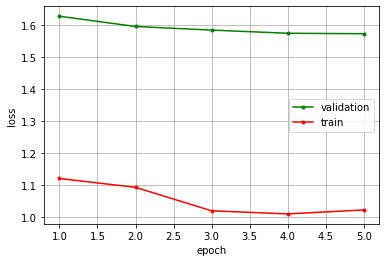

<Figure size 432x288 with 0 Axes>

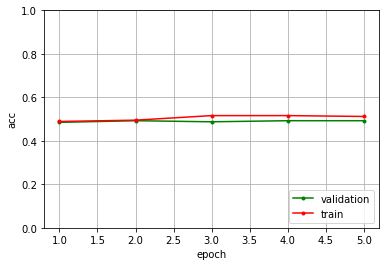

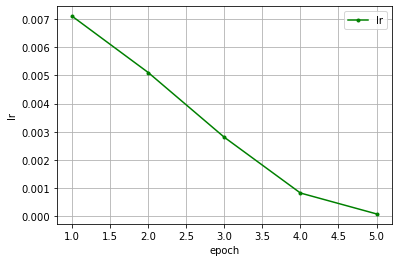

<Figure size 432x288 with 0 Axes>

In [17]:
import os
import matplotlib
#Jupyterでインライン表示するための宣言
%matplotlib inline
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'))

## valid,test setのloss,acc評価

In [18]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

In [19]:
# val_batch_size, test_batch_size の枚数だけevaluate
scoreSeg = model.evaluate_generator(d_cls.valid_gen, val_batch_size)
print("val_loss = ",scoreSeg[0])
print("val_acc = ",scoreSeg[1])

scoreSeg = model.evaluate_generator(d_cls.test_gen, test_batch_size)
print("\ntest_loss = ",scoreSeg[0])
print("test_acc = ",scoreSeg[1])

val_loss =  1.7512984931468965
val_acc =  0.49000000208616257

test_loss =  2.3284264504909515
test_acc =  0.3700000062584877


In [20]:
# evaluate_generator はflow_from_directory でラベルクラスが親ディレクトリである場合しか使えない評価関数（lossとaccを出す）
# なので、基本train/validation setにしか使えない（test setは正解ラベルないケースが普通なので）

# evaluate_generator はgenerator だけ引数に渡したら全件予測してくれるみたい
# ただし、batch size ごとに予測するから総数/batch_size が割り切れる数になっていないと、あまりの分が2回predictされてしまう
# 安全な方法はbatch_size=1 にしたgenerator で実行（複数一気にpredictしないから時間かかる）
# https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
scoreSeg = model.evaluate_generator(d_cls.valid_gen, steps=len(d_cls.valid_gen))
print("val_loss = ",scoreSeg[0])
print("val_acc = ",scoreSeg[1])

scoreSeg = model.evaluate_generator(d_cls.test_gen, steps=len(d_cls.test_gen))
print("\ntest_loss = ",scoreSeg[0])
print("test_acc = ",scoreSeg[1])

val_loss =  1.571941974759102
val_acc =  0.49250000678002837

test_loss =  1.719976894557476
test_acc =  0.5300000078976155


## predict+混同行列

In [21]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

In [22]:
# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.test_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
pred_df.head()

,Filename,PredictionLabel,PredictionScore
0,Cat\10024.jpg,Cat,0.814
1,Cat\10046.jpg,Dog,0.894
2,Cat\10070.jpg,Dog,0.939
3,Cat\10122.jpg,Dog,0.998
4,Cat\10136.jpg,Dog,0.917


y_pred_list_str: ['Cat' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Cat' 'Cat' 'Dog' 'Cat' 'Dog'
 'Cat' 'Dog' 'Cat' 'Cat' 'Dog' 'Cat' 'Cat' 'Cat' 'Cat' 'Dog' 'Dog' 'Dog'
 'Cat' 'Dog' 'Dog' 'Cat' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Cat' 'Cat'
 'Dog' 'Cat' 'Dog' 'Cat' 'Dog' 'Cat' 'Dog' 'Cat' 'Dog' 'Dog' 'Dog' 'Dog'
 'Cat' 'Dog' 'Dog' 'Cat' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Cat' 'Cat' 'Dog'
 'Cat' 'Dog' 'Dog' 'Dog' 'Dog' 'Cat' 'Cat' 'Dog' 'Cat' 'Dog' 'Dog' 'Cat'
 'Dog' 'Cat' 'Dog' 'Dog' 'Dog' 'Cat' 'Cat' 'Dog' 'Dog' 'Cat' 'Dog' 'Dog'
 'Cat' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Cat' 'Cat' 'Dog' 'Dog'
 'Cat' 'Cat' 'Dog' 'Dog' 'Dog' 'Cat' 'Cat' 'Dog' 'Dog' 'Cat' 'Dog' 'Dog'
 'Dog' 'Cat' 'Dog' 'Dog' 'Dog' 'Cat' 'Dog' 'Cat' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Cat' 'Dog' 'Cat' 'Dog' 'Dog' 'Dog' 'Dog' 'Cat' 'Cat'
 'Dog' 'Cat' 'Cat' 'Cat' 'Cat' 'Dog' 'Cat' 'Dog' 'Cat' 'Dog' 'Dog' 'Dog'
 'Dog' 'Cat' 'Cat' 'Dog' 'Cat' 'Dog' 'Cat' 'Dog' 'Dog' 'Cat' 'Cat' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Do

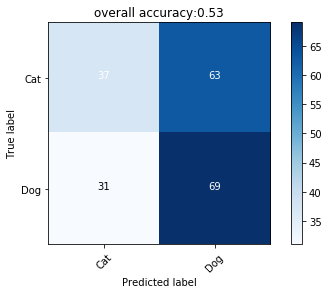

<Figure size 432x288 with 0 Axes>

In [23]:
# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df, classes, output_dir)

## 1件ずつ予測+GradCam

In [24]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train\Cat\10053.jpg


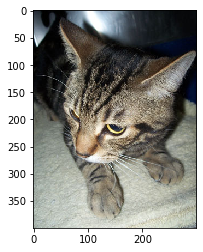

predict_score: [[0.34 0.66]]
classes: ['Cat', 'Dog']
max_pred_label:  Dog
pred_id: 1


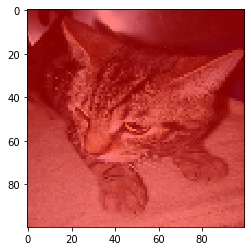

D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py\gradcam\FN\Cat_10053.jpg_pred_Dog.jpg


In [26]:
from keras.preprocessing import image

# 入力画像のファイルパス
data_paths = glob.glob(train_data_dir+'/**', recursive=True)
pred_path = data_paths[3]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'multiply_1', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

### K.set_learning_phase 指定無しのGradCamとK.set_learning_phase(0) のGradCamは同じ結果になる 

In [ ]:
from keras.preprocessing import image

import keras.backend as K
K.clear_session()
K.set_learning_phase(0)

#load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

# 入力画像のファイルパス
data_paths = glob.glob(train_data_dir+'/**', recursive=True)
pred_path = data_paths[3]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'activation_162', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

### K.set_learning_phase(1) はやっぱ間違い 
### K.set_learning_phase 指定無しのGradCamと違う結果になる 

In [ ]:
from keras.preprocessing import image

import keras.backend as K
K.clear_session()
K.set_learning_phase(1)

#load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

# 入力画像のファイルパス
data_paths = glob.glob(train_data_dir+'/**', recursive=True)
pred_path = data_paths[3]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'activation_162', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

### 他の画像でもGradCam実行

In [ ]:
import keras.backend as K
K.clear_session()
load_model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'))

D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation\Cat\4561.jpg


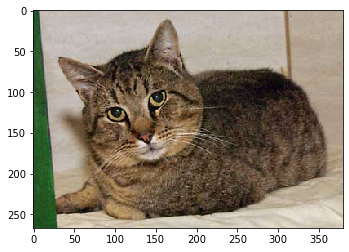

predict_score: [[0. 1.]]
classes: ['Cat', 'Dog']
max_pred_label:  Dog
pred_id: 1


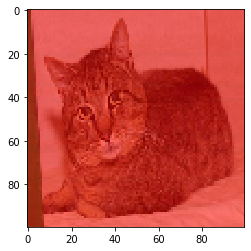

D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py\gradcam\FN\Cat_4561.jpg_pred_Dog.jpg


In [28]:
from keras.preprocessing import image

data_paths = glob.glob(validation_data_dir+'/**', recursive=True)
pred_path = data_paths[100]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'multiply_1', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\test\Cat\1076.jpg


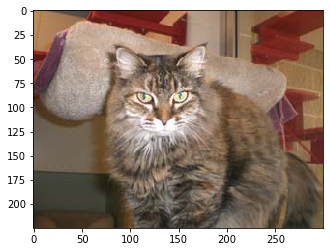

predict_score: [[0.35 0.65]]
classes: ['Cat', 'Dog']
max_pred_label:  Dog
pred_id: 1


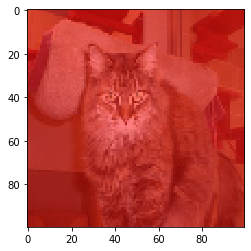

D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+attention_epoch10_from_02_keras_py\gradcam\FN\Cat_1076.jpg_pred_Dog.jpg


In [29]:
from keras.preprocessing import image

data_paths = glob.glob(test_dir+'/**', recursive=True)
pred_path = data_paths[13]

# grad_cam掛けるクラスid取得
pred_id, pred_score = base_predict.pred_from_1img(load_model, pred_path, img_rows, img_cols, classes)
print('pred_id:', str(pred_id))

# 入力画像ロード(image.load_img)してをarray型に変換(image.img_to_array)
x = image.img_to_array(image.load_img(pred_path, target_size=(img_rows, img_cols)))
X = grad_cam.preprocess_x(x)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'multiply_1', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = os.path.basename(os.path.dirname(pred_path)) # 正解ラベルであるファイルの直上のフォルダ名のみを取得
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, y_true_label+'_'+os.path.basename(pred_path)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


{'output_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\results\\InceptionResNetV2+attention_epoch10_from_02_keras_py', 'gpu_count': 1, 'img_rows': 100, 'img_cols': 100, 'channels': 3, 'batch_size': 50, 'classes': ['Cat', 'Dog'], 'num_classes': 2, 'train_data_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\images\\small_set\\train', 'validation_data_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\images\\small_set\\validation', 'test_data_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\images\\small_set\\validation', 'color_mode': 'rgb', 'class_mode': 'categorical', 'activation': 'softmax', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'model_path': None, 'num_epoch': 2, 'n_multitask': 1, 'multitask_pred_n_node': 1, 'weights': 'imagenet', 'choice_model': 'VGG16', 'fcpool': 'GlobalAveragePooling2D', 'is_skip_bn': True, 'trainable': 15, 'fcs': [], 'drop': 0.5, 'is_add_batchnorm': True, 'l2_rate': 0.0001, 'choice_optim': 'sgd', 'lr': 0.1, 'decay': 0.0, 'my_IDG_options': {'rescale': 0.

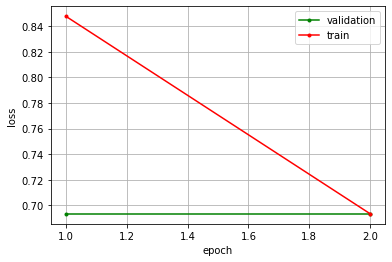

<Figure size 432x288 with 0 Axes>

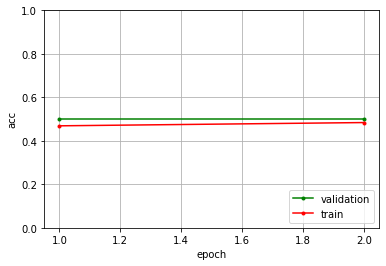

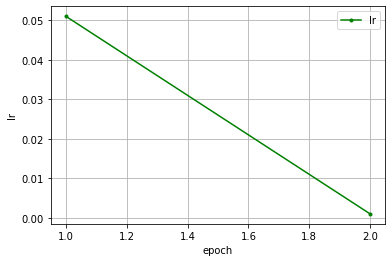

<Figure size 432x288 with 0 Axes>

In [1]:
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
import tmp

args = tmp.get_class_fine_tuning_parameter_base()
print(args)
tmp.train_flow_from_directory(args)

C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


my_IDG_options: {'rescale': 0.00392156862745098}
Found 400 images belonging to 2 classes.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Processing 399:  98%|██████████████████████████████████████████████████████████████▋ | 392/400 [00:06<00:00, 58.55it/s]
y_pred_list_str: ['Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog'
 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'Dog' 'D

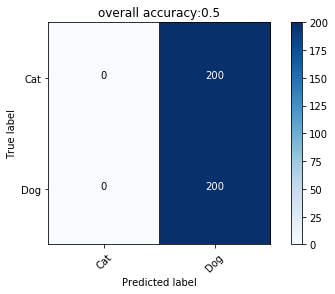

<Figure size 432x288 with 0 Axes>

In [1]:
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
import tmp

args = tmp.get_class_fine_tuning_parameter_base()
tmp.pred_flow_from_directory(args)

In [1]:
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
import tmp
import optuna

n_trials = 2
study_name = 'study'
tuning_output_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\results\VGG16' 

study = optuna.create_study(direction='minimize', study_name=study_name, storage=f"sqlite:///{tuning_output_dir}/{study_name}.db", load_if_exists=True)
study.optimize(tmp.Objective(), n_trials=n_trials)
study.trials_dataframe().to_csv(f"{tuning_output_dir}/{study_name}_history.csv", index=False)
print(f"\nstudy.best_params:\n{study.best_params}")
print(f"\nstudy.best_trial:\n{study.best_trial}")

C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.
[I 2020-01-14 23:41:24,060] A new study created with name: study


{'output_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\results\\VGG16', 'gpu_count': 1, 'img_rows': 100, 'img_cols': 100, 'channels': 3, 'batch_size': 50, 'classes': ['Cat', 'Dog'], 'num_classes': 2, 'train_data_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\images\\small_set\\train', 'validation_data_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\images\\small_set\\validation', 'color_mode': 'rgb', 'class_mode': 'categorical', 'activation': 'softmax', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'model_path': None, 'num_epoch': 2, 'n_multitask': 1, 'multitask_pred_n_node': 1, 'weights': 'imagenet', 'choice_model': 'VGG16', 'fcpool': 'attention', 'is_skip_bn': False, 'trainable': 400, 'efficientnet_num': 5, 'fcs': [100], 'drop': 0.5, 'is_add_batchnorm': False, 'l2_rate': 5e-05, 'choice_optim': 'adamax', 'lr': 0.1, 'decay': 1e-05, 'my_IDG_options': {'rescale': 0.00392156862745098, 'width_shift_range': 0.25, 'height_shift_range': 0.25, 'horizontal_flip': True, 'vertical_flip':

[I 2020-01-14 23:41:48,348] Finished trial#0 resulted in value: 0.9710536897182465. Current best value is 0.9710536897182465 with parameters: {'black_and_white': 0.5, 'brightness_range': [0.3, 1.0], 'channel_shift_range': 200, 'choice_model': 'VGG16', 'choice_optim': 'adamax', 'crop_area': 0.5, 'crop_by_centre': False, 'crop_by_height': 224, 'crop_by_size_prob': 0.0, 'crop_by_width': 224, 'crop_prob': 0.5, 'decay': 1e-05, 'drop': 0.5, 'efficientnet_num': 5, 'fcpool': 'attention', 'fcs': [100], 'flip_left_right': 0.5, 'flip_top_bottom': 0.0, 'greyscale': 0.5, 'height_shift_range': 0.25, 'horizontal_flip': True, 'invert': 0.0, 'is_add_batchnorm': False, 'is_base_aug': False, 'is_grayscale': False, 'is_skip_bn': False, 'l2_rate': 5e-05, 'lr': 0.1, 'mix_up_alpha': 0.0, 'random_dist_grid_height': 4, 'random_dist_grid_width': 4, 'random_dist_magnitude': 8, 'random_dist_prob': 0.0, 'random_erasing_area': 0.3, 'random_erasing_prob': 0.5, 'ricap_beta': 0.0, 'rotate180': 0.0, 'rotate270': 0.0, '

{'output_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\results\\VGG16', 'gpu_count': 1, 'img_rows': 100, 'img_cols': 100, 'channels': 3, 'batch_size': 50, 'classes': ['Cat', 'Dog'], 'num_classes': 2, 'train_data_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\images\\small_set\\train', 'validation_data_dir': 'D:\\work\\kaggle_data\\Cats_VS._Dogs\\images\\small_set\\validation', 'color_mode': 'rgb', 'class_mode': 'categorical', 'activation': 'softmax', 'loss': 'categorical_crossentropy', 'metrics': ['accuracy'], 'model_path': None, 'num_epoch': 2, 'n_multitask': 1, 'multitask_pred_n_node': 1, 'weights': 'imagenet', 'choice_model': 'VGG16', 'fcpool': 'GlobalAveragePooling2D', 'is_skip_bn': True, 'trainable': 400, 'efficientnet_num': 3, 'fcs': [512, 256], 'drop': 0.5, 'is_add_batchnorm': True, 'l2_rate': 0.0005, 'choice_optim': 'adam', 'lr': 0.01, 'decay': 0.0001, 'my_IDG_options': {'rescale': 0.00392156862745098, 'width_shift_range': 0.25, 'height_shift_range': 0.25, 'horizontal_flip': True,

[I 2020-01-14 23:42:15,829] Finished trial#1 resulted in value: 0.6931471824645996. Current best value is 0.6931471824645996 with parameters: {'black_and_white': 0.0, 'brightness_range': [1.0, 1.0], 'channel_shift_range': 0.0, 'choice_model': 'VGG16', 'choice_optim': 'adam', 'crop_area': 0.8, 'crop_by_centre': True, 'crop_by_height': 224, 'crop_by_size_prob': 0.5, 'crop_by_width': 224, 'crop_prob': 0.0, 'decay': 0.0001, 'drop': 0.5, 'efficientnet_num': 3, 'fcpool': 'GlobalAveragePooling2D', 'fcs': [512, 256], 'flip_left_right': 0.0, 'flip_top_bottom': 0.5, 'greyscale': 0.0, 'height_shift_range': 0.25, 'horizontal_flip': True, 'invert': 0.5, 'is_add_batchnorm': True, 'is_base_aug': False, 'is_grayscale': False, 'is_skip_bn': True, 'l2_rate': 0.0005, 'lr': 0.01, 'mix_up_alpha': 0.0, 'random_dist_grid_height': 4, 'random_dist_grid_width': 4, 'random_dist_magnitude': 8, 'random_dist_prob': 0.5, 'random_erasing_area': 0.3, 'random_erasing_prob': 0.5, 'ricap_beta': 0.3, 'rotate180': 0.0, 'ro


study.best_params:
{'black_and_white': 0.0, 'brightness_range': [1.0, 1.0], 'channel_shift_range': 0.0, 'choice_model': 'VGG16', 'choice_optim': 'adam', 'crop_area': 0.8, 'crop_by_centre': True, 'crop_by_height': 224, 'crop_by_size_prob': 0.5, 'crop_by_width': 224, 'crop_prob': 0.0, 'decay': 0.0001, 'drop': 0.5, 'efficientnet_num': 3, 'fcpool': 'GlobalAveragePooling2D', 'fcs': [512, 256], 'flip_left_right': 0.0, 'flip_top_bottom': 0.5, 'greyscale': 0.0, 'height_shift_range': 0.25, 'horizontal_flip': True, 'invert': 0.5, 'is_add_batchnorm': True, 'is_base_aug': False, 'is_grayscale': False, 'is_skip_bn': True, 'l2_rate': 0.0005, 'lr': 0.01, 'mix_up_alpha': 0.0, 'random_dist_grid_height': 4, 'random_dist_grid_width': 4, 'random_dist_magnitude': 8, 'random_dist_prob': 0.5, 'random_erasing_area': 0.3, 'random_erasing_prob': 0.5, 'ricap_beta': 0.3, 'rotate180': 0.0, 'rotate270': 0.0, 'rotate90': 0.5, 'rotate_max_left': 60, 'rotate_max_right': 60, 'rotate_prob': 0.0, 'rotation_range': 0.0, 

In [3]:
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
import tmp
import keras
from predicter import grad_cam
from dataset import util
from tqdm import tqdm

grad_cam_model_path = r'D:\work\kaggle_data\Cats_VS._Dogs\results\VGG16\best_val_loss.h5'
grad_cam_image_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\tmp\images'

keras.backend.clear_session()
keras.backend.set_learning_phase(0)
model = keras.models.load_model(grad_cam_model_path, compile=False)
for i,p in tqdm(enumerate(util.find_img_files(grad_cam_image_dir))):
    grad_cam.image2gradcam(model, p, is_gradcam_plus=False)

0it [00:00, ?it/s]

out_jpg: D:\work\kaggle_data\Cats_VS._Dogs\images\tmp\images/110_classidx0_gradcam.jpg


1it [00:00,  3.91it/s]

out_jpg: D:\work\kaggle_data\Cats_VS._Dogs\images\tmp\images/46_classidx0_gradcam.jpg


2it [00:00,  4.69it/s]

out_jpg: D:\work\kaggle_data\Cats_VS._Dogs\images\tmp\images/54_classidx0_gradcam.jpg
out_jpg: D:\work\kaggle_data\Cats_VS._Dogs\images\tmp\images/86_classidx0_gradcam.jpg


4it [00:00,  6.77it/s]


# --------------------------------------------------------------------------------------------

# Optunaで学習実行

In [1]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, plot_12task_log, util
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric, my_class_weight
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict
from tuning import optuna_train_base, optuna_train_Tox21, optuna_util

sys.path.append(r'C:\Users\shingo\Git\keras-squeeze-excite-network')
import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

import keras
import optuna
import numpy as np
import shutil
%matplotlib inline

# 入力ディレクトリ
train_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\train'
train_samples = util.file_count(train_data_dir, r'.jpg')

validation_data_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\images\small_set\validation'
val_samples = util.file_count(validation_data_dir, r'.jpg')

# 画像管理クラス
d_cls=get_train_valid_test.LabeledDataset([100, 100, 3]
                                          , 10
                                          , valid_batch_size=10
                                          , test_batch_size=10
                                          , train_samples = train_samples
                                          , valid_samples = val_samples
                                         )

# 基本コールバック
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1))
    
    return cb

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file
plot_12task_log.py: loaded as module file


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v4\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ndimage.py: loaded as module file
my_generator.py: loaded as module file
get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
my_class_weight.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file
ensemble_predict.py: loaded as module file
base_predict.py: loaded as module file
optuna_train_base.py: loaded as module file
optuna_train.py: loaded as module file
optuna_util.py: loaded as module file
train_steps_per_epoch : 100
valid_steps_per_epoch : 40


### 目的関数の定義
#### チューニング可能パラメータ
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル
    - fine-tuning
    - 全結合0-5層（重みの初期値はhe_normal(He の正規分布)で固定）
        - ユニット数 (同じ値か層ごとに減らす)
        - dropout_rate (全層同じ値になる)
        - Batch_Normalization (全層同じ値になる)
        - l2正則化(weight decay) (全層同じ値になる)
- オプティマイザ
- 学習率
    - 学習率変更なし
    - cosine_annealing(factor=0.01, epochs=None)
    - LearningRateScheduler(lr* 1/4 を3回する)
- データ水増し( keras.preprocessing.image.ImageDataGenerator )
    - 画像の剪断(shear)
    - 拡大縮小(zoom)
    - 回転(rotation)
    - 上下反転(vertical_flip)
    - 左右反転(horizontal_flip)
    - ランダムに画素値に値を足す（channel_shift_range）
    - ランダムに明度を変更（brightness_range）
    - 画像ランダムに切り取り（random_crop）
    - 画像の一部矩形領域を隠す（random_erasing)
    - 画像混ぜる(mix_up)

In [2]:
# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+SE+FC1_epoch10_from_02_keras_py\optuna'
os.makedirs(output_dir, exist_ok=True)

# Trueならbest_parameter をval_loss でとる。Falseならval_accでとる
return_val_loss=True#False

# Optunaでの枝刈り入れるか True ならval_lossで枝刈り
prune=True 

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['VGG16', 'Xception']#['PeleeNet']#['SEInceptionV3']#['Xception','InceptionResNetV2','NASNetLarge']# 学習済みモデル
trainable = ['all']#[116, 761, 1017, 'all'] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
decay=[0.0] # モデルのオプティマイザのdecay
FCnum = [0,1,2]#[1]#[0,1,2] # FC層の数
Dence = [512, 256, 128] # FC層のユニット数
Dropout = [0.0, 0.5] # FC層のDropout
kernel_initializer=['he_normal'] # FC層の重みの初期値
addBatchNorm = [None] # FC層のBatchNorm
l2 = [0.0, 5e-4] # FC層のl2
choice_optim = ['sgd', 'adam', 'nadam', 'adabound'] # optimizer
adam_amsgrad = [False, True] # Adam で学習率に過去の勾配の勾配の影響をゆっくりと減衰させるAMSGrad 含めるか。keras2.1.5以上から使える。keras.optimizers.Adam()のでデフォルトはFalse
lr = [1.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # （初期）学習率
callback_lr = [None, 'cosine_annealing'] # 学習率変更するcallback
callback_save_model=False#True # モデル保存するcallback つけるか. False なら保存しない

if callback_save_model == True:
    model_dir = os.path.join(output_dir, 'model_weight_optuna')

# クラスの不均衡を考慮して、トレーニングデータのclass_weight
class_name = ['Cat', 'Dog']
class_weight = my_class_weight.cal_weight(class_name, train_data_dir)
    
## ImageDataGenerator param
rescale=1.0/255.0 # 画像の前処理
horizontal_flip=[True]#[True, False]#[False] # 画像の左右反転
vertical_flip=[False]#[True, False]#[False] # 画像の上下反転
# 画像の回転の下限角、回転の上限角、回転角の刻み幅
rotation_range_min=0#-30 
rotation_range_max=30#30#0#180
rotation_unit=0.0# 0.0 にしたら rotation_range_max で固定
# 画像の縮小の最少-最大倍率、拡大の最少-最大倍率、縮小拡大倍率の刻み幅
zoom_range_low_min=0.1#1.0#0.5
zoom_range_low_max=1.0#1.0
zoom_range_high_min=1.0#1.0
zoom_range_high_max=1.9#1.0#1.5
zoom_range_unit=0.0#0.1 # 0.0 にしたら zoom_range_low_min, zoom_range_high_max で固定
# 画像のせん断の最少倍率、せん断の最大倍率、せん断倍率の刻み幅
shear_range_min=-0.0#0.0
shear_range_max=0.0#0.0#0.5
shear_range_unit=0.0#0.1 # 0.0 にしたら shear_range_max で固定
# ランダムに画素値に値を足す
channel_shift_range_min=-0.0#0.0
channel_shift_range_max=0.0#0.0#10.0
channel_shift_range_unit=0.0#0.1 # 0.0 にしたら channel_shift_range_max で固定
# ランダムに明度を変更 brightness_range=[0.3, 1.0]みたいなの
brightness_range_low_min=1.0#0.3
brightness_range_low_max=1.0
brightness_range_high_min=1.0
brightness_range_high_max=1.0#1.3
brightness_range_unit=0.0 # 0.0 ならランダムに明度変更倍率は固定値(self.brightness_range_low_min, self.brightness_range_high_max)
# 画像のrandom_crop.付ける場合は[224,224]とかにする
random_crop=None 
# random_erasing の確率. 使わない場合は0.0にする
random_erasing_prob=[0.5]#[0.0, 0.5] 
# random_erasing で消す領域の画素の最大値
random_erasing_maxpixel=255.0 
# mixup 含めるか
mix_up_alpha=[0.0, 0.2] 
# RICAP 含めるか
ricap_beta=[0.0, 0.3] 
ricap_use_same_random_value_on_batch=[True] # RICAP Trueとすれば論文と同じように「ミニバッチ間で共通の乱数を使う例」。Falseにすれば、「サンプル間で別々の乱数を使う例」

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train_base.Objective(out_dir=output_dir
                                        , d_cls=d_cls
                                        , train_data_dir=train_data_dir
                                        , validation_data_dir=validation_data_dir
                                        , shape=[100, 100, 3]
                                        , num_classes=len(class_name)
                                        , class_name=class_name
                                        , epochs=2
                                        , gpu_count=1
                                        , loss='categorical_crossentropy'
                                        , metrics=['acc']
                                        , verbose=2
                                        , activation='softmax'
                                        , pred_kernel_initializer='zeros'
                                        , pred_l2_rate=0.0001
                                        , FCpool=['GlobalAveragePooling2D']
                                        , return_val_loss=return_val_loss
                                        , callbacks=get_cb(output_dir, cosine_annealing_num_epoch=None)
                                        , callback_save_model=callback_save_model
                                        , choice_model=choice_model
                                        , trainable=trainable
                                        , decay=decay
                                        , FCnum=FCnum
                                        , Dence=Dence
                                        , Dropout=Dropout
                                        , addBatchNorm=addBatchNorm
                                        , kernel_initializer=kernel_initializer
                                        , l2=l2
                                        , choice_optim=choice_optim
                                        , adam_amsgrad=adam_amsgrad
                                        , lr=lr
                                        , callback_lr=callback_lr
                                        , class_weight=class_weight
                                        , rescale=rescale
                                        , horizontal_flip=horizontal_flip
                                        , vertical_flip=vertical_flip
                                        , rotation_range_min=rotation_range_min
                                        , rotation_range_max=rotation_range_max
                                        , rotation_unit=rotation_unit
                                        , zoom_range_low_min=zoom_range_low_min
                                        , zoom_range_low_max=zoom_range_low_max
                                        , zoom_range_high_min=zoom_range_high_min
                                        , zoom_range_high_max=zoom_range_high_max
                                        , zoom_range_unit=zoom_range_unit
                                        , shear_range_min=shear_range_min
                                        , shear_range_max=shear_range_max
                                        , shear_range_unit=shear_range_unit
                                        , channel_shift_range_min=channel_shift_range_min
                                        , channel_shift_range_max=channel_shift_range_max
                                        , channel_shift_range_unit=channel_shift_range_unit
                                        , brightness_range_low_min=brightness_range_low_min
                                        , brightness_range_low_max=brightness_range_low_max
                                        , brightness_range_high_min=brightness_range_high_min
                                        , brightness_range_high_max=brightness_range_high_max
                                        , brightness_range_unit=brightness_range_unit
                                        , random_crop=random_crop 
                                        , random_erasing_prob=random_erasing_prob
                                        , random_erasing_maxpixel=random_erasing_maxpixel
                                        , mix_up_alpha=mix_up_alpha
                                        , ricap_beta=ricap_beta
                                        , ricap_use_same_random_value_on_batch=ricap_use_same_random_value_on_batch
                                       )

### 最適化の実行

In [3]:
%%time
# sqlite 使って履歴ファイル作る
sqllite_path = output_dir+'/example.db'
if os.path.exists(sqllite_path) == True:
    os.remove(sqllite_path) # sqllite_pathすでにあれば一旦削除
study = optuna.create_study(study_name='example-study', storage='sqlite:///'+sqllite_path)

study.optimize(objective, n_trials=2)

[I 2019-09-25 00:38:08,687] A new study created with name: example-study


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+SE+FC1_epoch10_from_02_keras_py\optuna
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 all
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
Instructions for updating:
Colocations handled automatically by placer.


C:\Users\shingo\Anaconda3\envs\tfgpu_py36_v4\lib\site-packages\keras\engine\saving.py:292: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



----- FC_layer -----
---- choice_optim = adam ----
adam_lr adam_decay beta_1 beta_2 = 0.001 0.0 0.9 0.999
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 30, 'zoom_range': [0.1, 1.9], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.2, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255.0, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': True, 'is_base_aug': False}
Found 400 images belonging to 2 classes.
callback: [<model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x000001FB0B2CF780>, <model.my_callback.learning_curve_plot.<locals>._LearningCurvePlotter object at 0x000001FB1C2BDEF0>, <keras.callbacks.ModelCheckpoint object at 0x000001FB1C2BDF60>, <keras.callbacks.EarlyStopping object at 0x000001FB1C2BD860>, <keras.callbacks.ModelCheckpoint object at 0x000001FB40CC29B0>, <keras.callbacks.ModelCheckpoint object at 0x000001FB

C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\model\my_callback.py:159: MatplotlibDeprecationWarning:


The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.




Epoch 00002: val_loss improved from 0.69313 to 0.69311, saving model to D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+SE+FC1_epoch10_from_02_keras_py\optuna\finetuning.h5
check_loss, self.trial_best_loss: 0.693113824725151 1000.0
check_metrics, self.trial_best_metrics: 0.5 1000.0


[I 2019-09-25 00:38:55,776] Finished trial#0 resulted in value: 0.693113824725151. Current best value is 0.693113824725151 with parameters: {'FCnum': 0, 'FCpool': 'GlobalAveragePooling2D', 'adam_amsgrad': False, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': None, 'choice_model': 'VGG16', 'choice_optim': 'adam', 'decay': 0.0, 'efficientnet_num': 3, 'horizontal_flip': True, 'is_base_aug': False, 'lr': 0.001, 'mix_up_alpha': 0.2, 'oct_conv_alpha': 0.25, 'random_erasing_prob': 0.5, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 'all', 'vertical_flip': False, 'wrn_N': 4, 'wrn_k': 10}.


----- model_param -----
output_dir = D:\work\kaggle_data\Cats_VS._Dogs\results\InceptionResNetV2+SE+FC1_epoch10_from_02_keras_py\optuna
img_rows img_cols channels = 100 100 3
num_classes = 2
choice_model trainable = VGG16 all
FCnum = 0
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
----- FC_layer -----
---- choice_optim = adabound ----
adabound_lr adabound_final_lr adabound_decay beta_1 beta_2, amsbound = 1.0 10.0 0.0 0.9 0.999 True
my_IDG_options: {'rescale': 0.00392156862745098, 'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 30, 'zoom_range': [0.1, 1.9], 'shear_range': 0.0, 'channel_shift_range': 0.0, 'brightness_range': [1.0, 1.0], 'random_crop': None, 'mix_up_alpha': 0.0, 'random_erasing_prob': 0.5, 'random_erasing_maxpixel': 255.0, 'ricap_beta': 0.3, 'ricap_use_same_random_value_on_batch': True, 'is_base_aug': False}
Found 400 images belonging to 2 classes.
callback: [<model.

[I 2019-09-25 00:39:35,321] Finished trial#1 resulted in value: 8.063766128616408. Current best value is 0.693113824725151 with parameters: {'FCnum': 0, 'FCpool': 'GlobalAveragePooling2D', 'adam_amsgrad': False, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': None, 'choice_model': 'VGG16', 'choice_optim': 'adam', 'decay': 0.0, 'efficientnet_num': 3, 'horizontal_flip': True, 'is_base_aug': False, 'lr': 0.001, 'mix_up_alpha': 0.2, 'oct_conv_alpha': 0.25, 'random_erasing_prob': 0.5, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 'all', 'vertical_flip': False, 'wrn_N': 4, 'wrn_k': 10}.


Wall time: 1min 28s


### 結果の確認

In [4]:
# 試行結果データフレームで出力
study = optuna.Study(study_name='example-study', storage='sqlite:///'+sqllite_path)
df = study.trials_dataframe()
df.to_csv(os.path.join(output_dir, 'optuna_lgb.tsv'), sep='\t')
df

number                state     value             datetime_start  \
                                                                     
0      0  TrialState.COMPLETE  0.693114 2019-09-25 00:38:08.855582   
1      1  TrialState.COMPLETE  8.063766 2019-09-25 00:38:55.780320   

           datetime_complete params                                       \
                              FCnum                  FCpool adam_amsgrad   
0 2019-09-25 00:38:53.891469      0  GlobalAveragePooling2D        False   
1 2019-09-25 00:39:34.198878      0  GlobalAveragePooling2D         True   

                              ...     user_attrs                             \
  add_se branch_Tox21_12task  ... rotation_range          shape shear_range   
0  False               False  ...             30  [100, 100, 3]         0.0   
1  False               False  ...             30  [100, 100, 3]         0.0   

                                                   system_attrs  \
  val_acc  val_loss zoom_range_high zoom_range_low      _number   
0     0.5  0.693114             1.9            0.1            0   
1     0.5  8.063766             1.9            0.1            1   

  intermediate_values            
                    0         1  
0            0.693133  0.693114  
1            8.085871  8.063766  

[2 rows x 55 columns]

In [5]:
# study.best_params ファイル出力
f = open(os.path.join(output_dir, 'best_params.txt'), 'w') # 書き込みモードで開く
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
study.best_params

{'FCnum': 0,
 'FCpool': 'GlobalAveragePooling2D',
 'adam_amsgrad': False,
 'add_se': False,
 'branch_Tox21_12task': False,
 'callback_lr': None,
 'choice_model': 'VGG16',
 'choice_optim': 'adam',
 'decay': 0.0,
 'efficientnet_num': 3,
 'horizontal_flip': True,
 'is_base_aug': False,
 'lr': 0.001,
 'mix_up_alpha': 0.2,
 'oct_conv_alpha': 0.25,
 'random_erasing_prob': 0.5,
 'ricap_beta': 0.0,
 'ricap_use_same_random_value_on_batch': True,
 'sedensenet_num': None,
 'seresnet_num': None,
 'seresnext_num': None,
 'trainable': 'all',
 'vertical_flip': False,
 'wrn_N': 4,
 'wrn_k': 10}

In [6]:
study.best_trial 

FrozenTrial(number=0, state=<TrialState.COMPLETE: 1>, value=0.693113824725151, datetime_start=datetime.datetime(2019, 9, 25, 0, 38, 8, 855582), datetime_complete=datetime.datetime(2019, 9, 25, 0, 38, 53, 891469), params={'FCnum': 0, 'FCpool': 'GlobalAveragePooling2D', 'adam_amsgrad': False, 'add_se': False, 'branch_Tox21_12task': False, 'callback_lr': None, 'choice_model': 'VGG16', 'choice_optim': 'adam', 'decay': 0.0, 'efficientnet_num': 3, 'horizontal_flip': True, 'is_base_aug': False, 'lr': 0.001, 'mix_up_alpha': 0.2, 'oct_conv_alpha': 0.25, 'random_erasing_prob': 0.5, 'ricap_beta': 0.0, 'ricap_use_same_random_value_on_batch': True, 'sedensenet_num': None, 'seresnet_num': None, 'seresnext_num': None, 'trainable': 'all', 'vertical_flip': False, 'wrn_N': 4, 'wrn_k': 10}, user_attrs={'FCpool': "['GlobalAveragePooling2D']", 'acc': 0.5070000069588423, 'activation': 'softmax', 'brightness_range_high': '1.0', 'brightness_range_low': '1.0', 'callbacks': '[<model.my_callback.tsv_logger.<loca

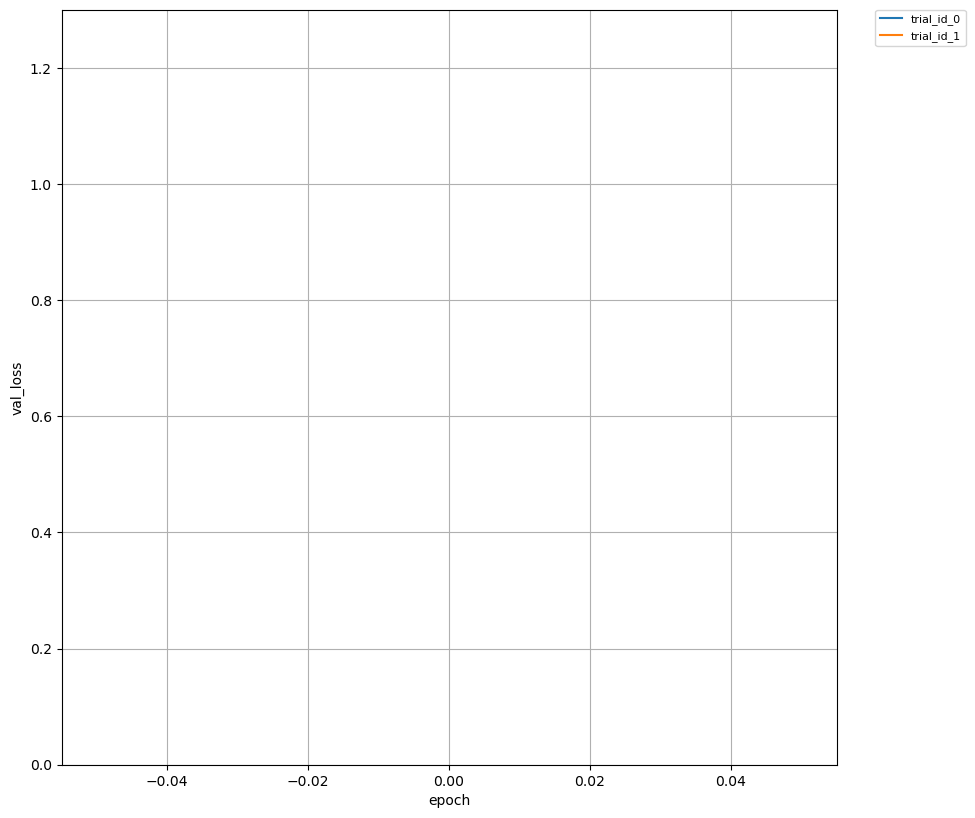

,Unnamed: 0,number,state,value,datetime_start,datetime_complete,params,params.1,params.2,params.3,...,user_attrs.15,user_attrs.16,user_attrs.17,user_attrs.18,user_attrs.19,user_attrs.20,user_attrs.21,system_attrs,intermediate_values,intermediate_values.1
0,NaN,NaN,NaN,NaN,NaN,NaN,FCnum,FCpool,adam_amsgrad,add_se,...,rotation_range,shape,shear_range,val_acc,val_loss,zoom_range_high,zoom_range_low,_number,0.000000,1.000000
1,0.0,0.0,TrialState.COMPLETE,0.693114,2019-09-25 00:38:08.855582,2019-09-25 00:38:53.891469,0,GlobalAveragePooling2D,False,False,...,30,"[100, 100, 3]",0.0,0.5,0.693113824725151,1.9,0.1,0,0.693133,0.693114
2,1.0,1.0,TrialState.COMPLETE,8.063766,2019-09-25 00:38:55.780320,2019-09-25 00:39:34.198878,0,GlobalAveragePooling2D,True,False,...,30,"[100, 100, 3]",0.0,0.5,8.063766128616408,1.9,0.1,1,8.085871,8.063766


<Figure size 432x288 with 0 Axes>

In [7]:
# trial結果ロード
import pandas as pd
result_df = pd.read_table(os.path.join(output_dir, 'optuna_lgb.tsv'))
# optunaのtrial結果plot
optuna_util.trial_plot(output_dir, result_df, epochs=1, val_name="val_loss", trial_id=None)# , trial_id=None # , trial_id=2 # , trial_id=[2,45,46,47,48,49]
result_df
